# Naive Bayesian - Multinomial

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The Gaussian assumption just described is by no means the only simple assumption that could be used to specify the generative distribution for each label.  Another useful example is multinomial naive bayes, where the features are assumed to be generated from a simple multinomial distribution.  **The multinomial distribution describes the probability of observing counts among a number of categories, and thus multinomial naive bayes is most appropriate for features that represent counts or count rates.**

The idea is precisely the same as before, except that instead of modeling the data distribution with the best-fit Gaussian, we model the data distribuiton with a best-fit multinomial distribution.

One place where multinomial naive Bayes is often used is in **text classification**, where the features $w$ are related to word counts or frequencies within the documents to be classified and $y$ will be our class.  The formation is as follows:

$$
P(y|w) = \frac{P(w|y)P(y)}{P(w)}
$$

## Implementation steps

1. Prepare your data
    - $\mathbf{X}$ and $\mathbf{y}$ in the right shape
        - $\mathbf{X}$ -> $(m, n)$
        - $\mathbf{y}$ -> $(m,  )$
        - Note that theta is not needed.  Why?
    - train-test split
    - feature scale
    - clean out any missing data
    - (optional) feature engineering

2. Using the train documents, calculate the **likelihoods** of each word.  Following multinomial distribution, for a given word $w_i$, we count how many of $w_i$ belong in class $k$, we then divide this by the count of all the words that belong to $k$. This gives us the conditional probability for a word $w$ given $k$:

    $$ P(w_i \in train \mid y=k) = \frac{count(w_i, k)}{\sum_{i=1}^{n} count(w_i, k)} $$
    
where $n$ stands for number of unique vocabulary (i.e., features) and $m$ stands for number of documents (i.e., samples). 

Example:

| | docID  | words in doc    | China?   |    
|---:|:-------------|:-----------|:------|
| Training set | 1  | Chinese Beijing Chinese       | Yes   |
|  | 2  | Chinese Chinese Shanghai    | Yes  |
|  | 3  | Chinese Macao    | Yes   |
|  | 4  | Tokyo Japan Chinese   | No   |
| Test set | 5  | Chinese Chinese Chinese Tokyo Japan    | ?   |


In [2]:
#let's define some random dataset
train = np.array([
    'Chinese Beijing Chinese',
    'Chinese Chinese Shanghai',
    'Chinese Macao',
    'Tokyo Japan Chinese',
])

test = np.array([
    'Chinese Chinese Chinese Tokyo Japan'
])

train_target = np.array([1, 1, 1, 0])

In [3]:
#let's use some library to count for us
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train)
print("Feature names: ", vectorizer.get_feature_names_out())
print("Type: ", type(X_train))
print(X_train.toarray())  #the default is a sparse matrix, use toarray() to see it in the familiar numpy form

Feature names:  ['beijing' 'chinese' 'japan' 'macao' 'shanghai' 'tokyo']
Type:  <class 'scipy.sparse._csr.csr_matrix'>
[[1 2 0 0 0 0]
 [0 2 0 0 1 0]
 [0 1 0 1 0 0]
 [0 1 1 0 0 1]]


In [4]:
#the likelihood is very easy, i.e., count of each word belonging to that class / total count of words belonging to that class
def likelihood(X_class):
    return ((X_class.sum(axis=0))) / (np.sum(X_class.sum(axis=0)))

In [5]:
X_train_class1 = X_train[train_target == 1] 
X_train_class0 = X_train[train_target == 0]

print("Feature names: \n", vectorizer.get_feature_names_out())

print("====When y = 1=====")
print("X_train\n", X_train_class1.toarray())
print("Count of each word: ", X_train_class1.sum(axis=0))
print("Total count of words: ", np.sum(X_train_class1.sum(axis=0)))

likelihood1 = likelihood(X_train_class1)
print("P(X_train | y = 1): \n", likelihood1)
#P(word    | y = 1) = count of word / total words
#P(beijing | y = 1) = 1 / 8 = 0.125
#P(chinese | y = 1) = 5 / 8 = 0.625
#P(japan   | y = 1) = 0 / 8 = 0
#P(macao   | y = 1) = 1 / 8 = 0.125
#P(shanghai| y = 1) = 1 / 8 = 0.125
#P(tokyo   | y = 1) = 0 / 8 = 0.125

print("====When y = 0=====")
print("X_train\n", X_train_class0.toarray())
print("Count of each word: ", X_train_class0.sum(axis=0))
print("Total count of words: ", np.sum(X_train_class0.sum(axis=0)))

likelihood0 = likelihood(X_train_class0)
print("P(X_train | y = 0): \n", likelihood0)
#P(beijing | y = 0) = 0 / 3 = 0
#P(chinese | y = 0) = 1 / 3 = 0.33
#P(japan   | y = 0) = 1 / 3 = 0.33
#P(macao   | y = 0) = 0 / 3 = 0
#P(shanghai| y = 0) = 0 / 3 = 0
#P(tokyo   | y = 0) = 1 / 3 = 0.33


Feature names: 
 ['beijing' 'chinese' 'japan' 'macao' 'shanghai' 'tokyo']
====When y = 1=====
X_train
 [[1 2 0 0 0 0]
 [0 2 0 0 1 0]
 [0 1 0 1 0 0]]
Count of each word:  [[1 5 0 1 1 0]]
Total count of words:  8
P(X_train | y = 1): 
 [[0.125 0.625 0.    0.125 0.125 0.   ]]
====When y = 0=====
X_train
 [[0 1 1 0 0 1]]
Count of each word:  [[0 1 1 0 0 1]]
Total count of words:  3
P(X_train | y = 0): 
 [[0.         0.33333333 0.33333333 0.         0.         0.33333333]]


3. Since nothing in this world has zero probability, similarly, even we never see a particular word in some class should not gaurantee a zero probability, thus we can perform **Laplace smoothing** to account for any words with zero count.  Also zero probability is not good when we do a product of probabilities.

    $$ P(w_i \in train \mid y=k) = \frac{count(w_i, k) + 1}{\sum_{i=1}^{n} count(w_i, k) + n} $$



In [6]:
def likelihood(X_class, laplace=1):
    return ((X_class.sum(axis=0)) + laplace) / (np.sum(X_class.sum(axis=0) + laplace))

In [7]:
#rerun the new likelihood function
likelihood1 = likelihood(X_train_class1)
likelihood0 = likelihood(X_train_class0)

print("P(X_train | y = 1) with laplace: \n", np.round(likelihood1, 3))
#P(beijing | y = 1) = (1 + 1) / (8 + 6) = 0.143
#P(chinese | y = 1) = (5 + 1) / (8 + 6) = 0.429
#P(japan   | y = 1) = (0 + 1) / (8 + 6) = 0.071
#P(macao   | y = 1) = (1 + 1) / (8 + 6) = 0.143
#P(shanghai| y = 1) = (1 + 1) / (8 + 6) = 0.143
#P(tokyo   | y = 1) = (0 + 1) / (8 + 6) = 0.071

print("P(X_train | y = 0) with laplace: \n", np.round(likelihood0, 3))
#P(beijing | y = 0) = (0 + 1) / (3 + 6) = 0.11
#P(chinese | y = 0) = (1 + 1) / (3 + 6) = 0.22
#P(japan   | y = 0) = (1 + 1) / (3 + 6) = 0.22
#P(macao   | y = 0) = (0 + 1) / (3 + 6) = 0.11
#P(shanghai| y = 0) = (0 + 1) / (3 + 6) = 0.11
#P(tokyo   | y = 0) = (1 + 1) / (3 + 6) = 0.22

P(X_train | y = 1) with laplace: 
 [[0.143 0.429 0.071 0.143 0.143 0.071]]
P(X_train | y = 0) with laplace: 
 [[0.111 0.222 0.222 0.111 0.111 0.222]]


4. Find **priors** $P(y)$ which is simply number of documents belonging to that class divided by all documents

$$P(y = k) = \frac{\Sigma_{i=1}^{m}1(y=k)}{m} $$

In [8]:
prior1 = len(train_target[train_target==1])/len(train_target)
prior0 = len(train_target[train_target==0])/len(train_target)

print("Target: ", train_target)
print("Prior 1 (P(y=1)): ", prior1)
print("Prior 0 (P(y=0)): ", prior0)

Target:  [1 1 1 0]
Prior 1 (P(y=1)):  0.75
Prior 0 (P(y=0)):  0.25


5. Once we get the **likelihoods** from the train data.  If given some test data, we simply use this likelihood to calculate the total likelihood of the test document.  Similarly, since we have more than one word in the test document, we need to make a product of all likelihood of each word in the test document.    
    $$ P(w \in test \mid y=k) = \prod_{i=1}^{n} P(w_i \mid y=k)^{\text{freq of }w_i}$$
    
Then we can multiply $P(y = k)P(w \in test \mid y = k)$ for each class which will give us $P (y = k \mid w \in test)$ (**posteriors**)

$$P (y = k \mid w \in test) = P(y=k)\prod_{i=1}^{n} P(w_i \mid y=k)^{\text{freq of }w_i}$$

In [9]:
#let's first recall what is our test dataset
#also transform to the count matrix, using the training set count model (thus, only transform, no "fit")

test = np.array([
    'Chinese Chinese Chinese Tokyo Japan'
])

X_test = vectorizer.transform(test)
print("Feature names: ", vectorizer.get_feature_names_out())
print("Type: ", type(X_test))
print(X_test.toarray())

Feature names:  ['beijing' 'chinese' 'japan' 'macao' 'shanghai' 'tokyo']
Type:  <class 'scipy.sparse._csr.csr_matrix'>
[[0 3 1 0 0 1]]


In [10]:
#let's first print the likelihoods we get from the training set
print("Feature names: \n", vectorizer.get_feature_names_out())
print("Likelihood 1: ", likelihood1)
print("Likelihood 0: ", likelihood0)

pxtest_y1 = np.prod(np.power(likelihood1, X_test.toarray()))
# = 0.142^0 * 0.428^3 * 0.07^1 * 0.142^0 * 0.142^0 * 0.07^1
pxtest_y0 = np.prod(np.power(likelihood0, X_test.toarray()))
# = 0.11^0 * 0.22^3 * 0.22^1 * 0.11^0 * 0.11^0 * 0.22^1

print("P(X_test | y = 1): ", pxtest_y1)
print("P(X_test | y = 0): ", pxtest_y0)

Feature names: 
 ['beijing' 'chinese' 'japan' 'macao' 'shanghai' 'tokyo']
Likelihood 1:  [[0.14285714 0.42857143 0.07142857 0.14285714 0.14285714 0.07142857]]
Likelihood 0:  [[0.11111111 0.22222222 0.22222222 0.11111111 0.11111111 0.22222222]]
P(X_test | y = 1):  0.0004016183732968405
P(X_test | y = 0):  0.0005419228098697689


In [11]:
#last, we can multiply with the prior to get the posterior (p(y|x))
py1_x = prior1 * pxtest_y1
py0_x = prior0 * pxtest_y0

print("P(y=1|X_test) = p(y=1)p(X_test|y=1): ", py1_x)
print("P(y=0|X_test) = p(y=0)p(X_test|y=0): ", py0_x)

P(y=1|X_test) = p(y=1)p(X_test|y=1):  0.00030121377997263036
P(y=0|X_test) = p(y=0)p(X_test|y=0):  0.00013548070246744223


6. Instead of probabilities, we gonna use log (base e) probabiities which have several benefits:
    - **Speed** - Log probabilities become addition, which is faster than multiplication
    - **Stability** - Probabilities can be too small where some significant digits can be lost during calculations. Log probabiities can prevent such underflow.  If you don't believe me, try perform $\log_e(0.0000001)$
    - **Simplicity** - Many distributions have exponential form.  Taking log cancels out the exp.  The reason we can apply $\log$ is because $\log$ is a monotically increasing function, thus will not alter the result 
    - **Dot product** - After log, addition can often expressed as dot product of matrix, simplifying the code implementation
    
   Now that you are convinced, we can change
   
   $$P (y = k \mid w \in test) = P(y=k)\prod_{i=1}^{n} p(w_i \mid y=k)^{\text{freq of }w_i}$$  
   
   to
   
  $$P (y = k \mid w \in test) = \log \ P(y=k) + \sum_{i=1}^{n} (\text{freq of }w_i) * \log \ p(w_i \mid y=k)$$
  - Note 1: Log of multiplication becomes addition
  - Note 2: Exponent of log becomes multiplicative scalar
  
 Thus, in implementation we can expressed as

<code>np.log(priors) + X_test @ np.log(likelihoods.T) </code>

In [12]:
likelihood0

matrix([[0.11111111, 0.22222222, 0.22222222, 0.11111111, 0.11111111,
         0.22222222]])

In [13]:
X_test.toarray()

array([[0, 3, 1, 0, 0, 1]])

In [14]:
#let's recompute using the log way
pxtest_y1 = X_test.toarray() @ np.log(likelihood1.T)
pxtest_y0 = X_test.toarray() @ np.log(likelihood0.T)

print("P(X_test | y = 1): ", pxtest_y1)
print("P(X_test | y = 0): ", pxtest_y0)

P(X_test | y = 1):  [[-7.82000824]]
P(X_test | y = 0):  [[-7.52038698]]


In [15]:
X_test.toarray()

array([[0, 3, 1, 0, 0, 1]])

In [33]:
prior0

0.25

In [16]:
py1_x = np.log(prior1) + pxtest_y1
py0_x = np.log(prior0) + pxtest_y0

print("P(y=1|X_test) = p(y=1) + p(X_test|y=1): ", py1_x)
print("P(y=0|X_test) = p(y=0) + p(X_test|y=0): ", py0_x)

P(y=1|X_test) = p(y=1) + p(X_test|y=1):  [[-8.10769031]]
P(y=0|X_test) = p(y=0) + p(X_test|y=0):  [[-8.90668135]]


## Putting them together

### 1. Prepare some data

Here we will use the sparse word count features from the 20 Newsgroups corpus to show how we might classify these short documents into categories.

Let's download the data and take a look at the target names.

In [17]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Also, for simplicity here, we will select just a few of these categories, and download the training and testing set.

In [18]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

Last, we will print some example data.

In [19]:
print(train.data[0]) #first 300 words
print("Target: ", train.target[0])  #start with 1, soc.religion.christian

From: jono@mac-ak-24.rtsg.mot.com (Jon Ogden)
Subject: Re: Losing your temper is not a Christian trait
Organization: Motorola LPA Development
Lines: 26

In article <Apr.23.02.55.47.1993.3138@geneva.rutgers.edu>, jcj@tellabs.com
(jcj) wrote:

> I'd like to remind people of the withering of the fig tree and Jesus
> driving the money changers et. al. out of the temple.  I think those
> were two instances of Christ showing anger (as part of His human side).
> 
Yes, and what about Paul saying:

26 Be ye angry, and sin not: let not the sun go down upon your wrath:
(Ephesians 4:26).

Obviously then, we can be angry w/o sinning.

Jon

------------------------------------------------
Jon Ogden         - jono@mac-ak-24.rtsg.mot.com
Motorola Cellular - Advanced Products Division
Voice: 708-632-2521      Data: 708-632-6086
------------------------------------------------

They drew a circle and shut him out.
Heretic, Rebel, a thing to flout.
But Love and I had the wit to win;
We drew a circle and 

### 2. Transform our data to frequency

In [20]:
#transform our X to frequency data
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train.data)
X_test = vectorizer.transform(test.data)
X_test = X_test.toarray()  #vectorizer gives us a sparse matrix; convert back to dense matrix

y_train = train.target
y_test = test.target

print("X_train: ", X_train[0])
print("y_train: ", y_train[0])

X_train:    (0, 14822)	1
  (0, 18774)	2
  (0, 20502)	2
  (0, 4688)	2
  (0, 1572)	2
  (0, 27916)	2
  (0, 21988)	2
  (0, 9095)	3
  (0, 18765)	3
  (0, 23326)	2
  (0, 30617)	1
  (0, 26562)	1
  (0, 20308)	1
  (0, 35183)	2
  (0, 31463)	1
  (0, 18370)	1
  (0, 22932)	3
  (0, 8590)	1
  (0, 32244)	1
  (0, 23591)	1
  (0, 22013)	2
  (0, 20366)	1
  (0, 11327)	1
  (0, 20065)	1
  (0, 1655)	3
  :	:
  (0, 8236)	1
  (0, 4416)	1
  (0, 25675)	1
  (0, 11891)	1
  (0, 33990)	1
  (0, 2879)	2
  (0, 2691)	2
  (0, 1631)	1
  (0, 10677)	1
  (0, 2645)	1
  (0, 31737)	1
  (0, 12166)	2
  (0, 8666)	2
  (0, 29122)	1
  (0, 16610)	2
  (0, 16493)	1
  (0, 26646)	1
  (0, 31753)	1
  (0, 14421)	1
  (0, 7576)	1
  (0, 20341)	1
  (0, 16025)	1
  (0, 34678)	1
  (0, 34604)	1
  (0, 32091)	1
y_train:  2


### 3. Calculating likelihood anrd prior

In [21]:
def likelihood(X_class, laplace=1):
    return ((X_class.sum(axis=0)) + laplace) / (np.sum(X_class.sum(axis=0) + laplace))

In [22]:
def prior(X_class, m):
    return X_class.shape[0] / m

In [23]:
def fit(X_train, y_train):
    m, n = X_train.shape
    classes = np.unique(y_train)  #list of class
    k = len(classes) #number of class
    
    priors = np.zeros(k) #prior for each classes
    likelihoods = np.zeros((k, n)) #likehood for each class of each feature
    
    for idx, label in enumerate(classes):
        X_train_c = X_train[y_train==label]
        priors[idx] = prior(X_train_c, m)
        likelihoods[idx, :] = likelihood(X_train_c)
    return priors, likelihoods

### 4. Predict

In [24]:
def predict(X_test, priors, likelihoods, classes):
    return np.log(priors) + X_test @ np.log(likelihoods.T) 

### 5. Let's use them

In [25]:
priors, likelihoods = fit(X_train, y_train)

In [26]:
classes = np.unique(y_test)
yhat = predict(X_test, priors, likelihoods, classes)
yhat = np.argmax(yhat, axis=1)

In [27]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score, classification_report

n_classes = len(np.unique(y_test))

print("Accuracy: ", np.sum(yhat == y_test)/len(y_test))

print("=========Average precision score=======")
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])
yhat_binarized = label_binarize(yhat, classes=[0, 1, 2, 3])

for i in range(n_classes):
    class_score = average_precision_score(y_test_binarized[:, i], yhat_binarized[:, i])
    print(f"Class {i} score: ", class_score)
    
print("=========Classification report=======")
print("Report: ", classification_report(y_test, yhat))

Accuracy:  0.9168994413407822
=========Average precision score=======
Class 0 score:  0.9152047938418233
Class 1 score:  0.9069918620723723
Class 2 score:  0.8429395016564877
Class 3 score:  0.7277310085946386
=========Classification report=======
Report:                precision    recall  f1-score   support

           0       0.95      0.95      0.95       389
           1       0.94      0.96      0.95       394
           2       0.87      0.95      0.91       398
           3       0.92      0.74      0.82       251

    accuracy                           0.92      1432
   macro avg       0.92      0.90      0.91      1432
weighted avg       0.92      0.92      0.92      1432



Text(50.72222222222221, 0.5, 'predicted')

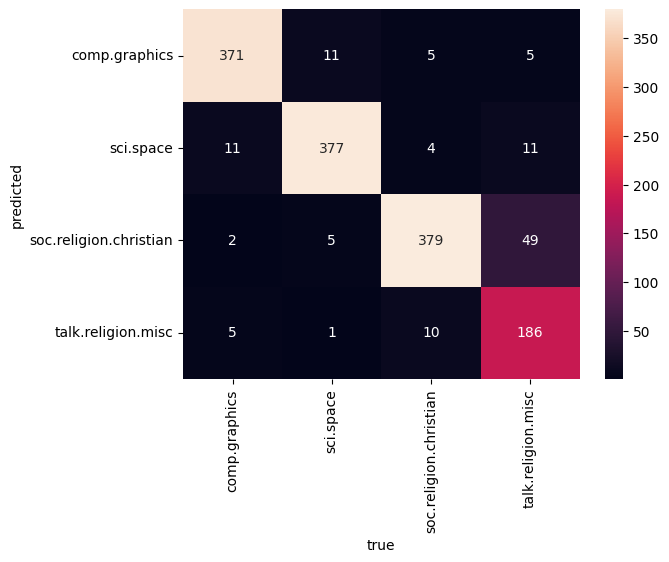

In [28]:
from sklearn.metrics import confusion_matrix

#use confusion matrix
mat = confusion_matrix(y_test, yhat)

import seaborn as sns
sns.heatmap(mat.T, annot=True, fmt="d",
           xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true')
plt.ylabel('predicted')

## Sklearn

In [29]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train, y_train)
yhat = model.predict(X_test)  ##later for checking score

In [30]:
#fun thing you can do
some_string = "Programming is fun"
transformed = vectorizer.transform([some_string])
transformed.shape

prediction = model.predict(transformed)
print(train.target_names[prediction[0]])

comp.graphics


In [31]:
print("=========Average precision score=======")
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])
yhat_binarized = label_binarize(yhat, classes=[0, 1, 2, 3])

n_classes = len(np.unique(y_test))

for i in range(n_classes):
    class_score = average_precision_score(y_test_binarized[:, i], yhat_binarized[:, i])
    print(f"Class {i} score: ", class_score)

print("=========Classification report=======")
print("Report: ", classification_report(y_test, yhat))

=========Average precision score=======
Class 0 score:  0.9152047938418233
Class 1 score:  0.9069918620723723
Class 2 score:  0.8429395016564877
Class 3 score:  0.7277310085946386
=========Classification report=======
Report:                precision    recall  f1-score   support

           0       0.95      0.95      0.95       389
           1       0.94      0.96      0.95       394
           2       0.87      0.95      0.91       398
           3       0.92      0.74      0.82       251

    accuracy                           0.92      1432
   macro avg       0.92      0.90      0.91      1432
weighted avg       0.92      0.92      0.92      1432



### When to Use Naive Bayes

Usually only as baseline!  Because naive Bayesian classifiers make such stringent assumptions about data, they will **generally NOT perform as well as a more complicated model.**
That said, they have several advantages:

- They are extremely fast for both training and prediction
- They provide straightforward probabilistic prediction
- They are often very easily interpretable
- They have very few (if any) tunable parameters

The cons is obviously lies on its naive assumption on statistical distribution, since statistical distribution, e.g., Gaussian or Multinomial may not fully/accurately capture the data characteristics.

## Group Workshop - Check your understandings

Training data
| | docID  | words in doc    | Pos?   |    
|---:|:-------------|:-----------|:------|
| Training set | 1  | Love Love Great       | Yes   |
|  | 2  | Love Great Nice    | Yes  |
|  | 3  | Love Wow No   | Yes   |
|  | 4  | No No Nice Dislike   | No   |
| Test set | 5  | Love Love Dislike Wow Nice Japan  |   ?   |

1. Compare Gaussian Naive Baye vs. Multinomial Naive Bayesian.  In which case should we use which?
2. In MNB, what are the features?  How it's different from GNB?
3. Does MNB has theta?  Why?
4. There is one more type of naive bayesian classifier (aside from multinomial and gaussian), i.e., Bernoulli, which simply count whether something exists, i.e., 0 or 1.   Please learn more about that by yourself.
5. Read the API of `CountVectorizer`.  One of the parameter is `ngram_range`.  What is it?
6. Go home and learn about `TfidfVectorizer`.  It is usually preferred over `CountVectorizer`.  I have put `TfidVectorizer` in the Appendix.
7. Based on the above data, practice the followings by hand:
   1. Acquire the count matrix that represents the frequencies of each word in each document.   In general, what is the shape of this matrix?  Notate it using variable.
   2. Calculate $ P(w_i \in train \mid y=k) $
   3. Calculate $ P(w_i \in train \mid y=k) $ using Laplace smoothing.  We shall use this answer for the future questions.
   4. Calculate $ P(y = k) $
   5. Calculate $ P(w \in test \mid y=k) $ using the $\log$ method, i.e., $ (\text{freq of }w_i) * \sum_{i=1}^{n} \log \ p(w_i \mid y=k)$
   6. Finally, calculate the posteriors $P (y \mid x)$

## Appendix: TfidfVectorizer

Recall that in Naive Multinomial Classification, we want our features to be represented as frequency.  Here, we shall go beyond one more step, i.e., after counting the number of words, we shall perform a normalization process called TF-IDF which focuses on **cutting very frequent words which tend to be less meaningful information like "the", "a", "is".**

In [32]:
from sklearn.feature_extraction.text import TfidfTransformer

#imagine that we already have a frequency features.  We can perform normalization
#as a follow up
#here we got n=3, and m=2
counts = [[3, 0, 1],
          [2, 1, 0],
          [3, 2, 5]]
transformer = TfidfTransformer()
transformer.fit_transform(counts).toarray()

array([[0.91892665, 0.        , 0.39442846],
       [0.84080197, 0.54134281, 0.        ],
       [0.39706158, 0.34085938, 0.85214845]])

Here is how it works underhood:

The formula is

$$ \text{TF-IDF} =  \text{TF} * \text{IDF} $$

where TF is 

$$ \text{TF}_t = \frac{\text{Count of words t in that document}}{\text{Total count of words in that document}}$$

Thus TF = 

| | 1st word  | 2nd word   | 3rd word |
|---:|:-------------|:-----------|:-----------|
| doc1 | 3/4 = 0.75  | 0     |  1/4 = 0.25 |
| doc2 | 2/3 = 0.66  | 1/3 = 0.33    |  0 |
| doc3 | 3/10 = 0.33  | 2/10 = 0.20    |  5/10 = 0.5 |

and 

$$ \text{IDF} = \log\left(\frac{\text{Number of documents}}{\text{Number of documents containing that word}}\right) + 1$$

*Note:  We plus one so that super frequent words will not be ignored entirely*

Thus IDF = 

| | IDF  |    
|---:|:-----------|
| 1st word | $\log$ 3/3 + 1 = 1 |
| 2nd word | $\log$ 3/2 + 1 = 1.4055  |
| 3rd word | $\log$ 3/2 + 1 = 1.4055  | 

*Notice that terms (i.e., 1st word) that appear frequently across documents will get low score.  By multiplying this IDF term with the frequency, it will scale the importance down.*

Thus TF * IDF = 

| | 1st word  | 2nd word | 3rd word|    
|---:|:-----------|:-----------|:-----------|
| doc1 | 0.75 * 1 = 0.75  | 0 * 1.4055 = 0 | 0.25 * 1.4055 = 0.3514 |
| doc2 | 0.66 * 1 = 0.66  | 0.33 * 1.4055 = 0.4685 | 0 * 1.4055 = 0   |
| doc3 | 0.33 * 1 = 0.33  | 0.20 * 1.4055 = 0.2811 | 0.5 * 1.4055 =0.7027   |


We need to further normalize each word using this formula (since each document has unequaled number of words):

$$ norm(t_i) = \frac{t_i}{\sqrt{t_1^2 + t_2^2 + ....+t_n^2}} $$ 

Thus, normalized factor for each document is

doc1 = $\sqrt{0.75^2 + 0^2 + 0.3514^2} = 0.8282$

doc2 = $\sqrt{0.66^2 + 0.4685^2 + 0^2} = 0.8094$

doc3 = $\sqrt{0.33^2 + 0.281^2 + 0.7027^2} = 0.8256$


Thus, normalized(TF * IDF) = 

| | 1st word  | 2nd word | 3rd word|    
|---:|:-----------|:-----------|:-----------|
| doc1 | 0.75 / 0.8282 = 0.9056 | 0 | 0.3514 / 0.8282 = 0.4243 |
| doc2 | 0.66 / 0.8094 = 0.8154  | 0.4685 / 0.8094 = 0.5788 | 0   |
| doc3 | 0.33 / 0.8256 = 0.3997  | 0.2811 / 0.8256 = 0.3405 | 0.7027 / 0.8256 = 0.8511 |

**Note**
- My numbers are not exactly the same due to float precisions
- Note I am using `TfidfTransformer`.  You may want to use `TfidfVectorizer` which automatically accepts raw data (i.e., text data)